In [26]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import nasdaqdatalink
import os
from dotenv import load_dotenv
from statsmodels.api import OLS, add_constant
load_dotenv()
API_KEY= os.getenv('API_KEY')
nasdaqdatalink.ApiConfig.api_key = API_KEY

# Load in Asset Data

In [3]:

# Define the asset universe
tickers = {
    # US Equities
    'SPY': 'QUOTEMEDIA/PRICES',  # S&P 500 ETF
    'QQQ': 'QUOTEMEDIA/PRICES',  # Nasdaq 100 ETF
    'IWM': 'QUOTEMEDIA/PRICES',  # Russell 2000 ETF (Small Cap)
    # International Equities
    'EFA': 'QUOTEMEDIA/PRICES',  # MSCI EAFE ETF (Developed Markets ex-US/Canada)
    'EEM': 'QUOTEMEDIA/PRICES',  # MSCI Emerging Markets ETF
    # Fixed Income
    'AGG': 'QUOTEMEDIA/PRICES',  # US Aggregate Bond ETF
    'TLT': 'QUOTEMEDIA/PRICES',  # US 20+ Year Treasury Bond ETF
    # Commodities
    'GLD': 'QUOTEMEDIA/PRICES',  # Gold ETF
    'USO': 'QUOTEMEDIA/PRICES',  # Oil ETF
    # Real Estate
    'VNQ': 'QUOTEMEDIA/PRICES',   # US Real Estate ETF
    # Adding a couple more for diversity
    'GSG': 'QUOTEMEDIA/PRICES', # Broad Commodities ETF
    'HYG': 'QUOTEMEDIA/PRICES'  # High Yield Corporate Bond ETF
}

start_date = '2010-01-01'


In [4]:
# Fetch data for each ticker
all_data = {}
for ticker, table in tickers.items():
    try:
        # Fetch data from the specified start_date
        data = nasdaqdatalink.get_table(
            table, 
            ticker=ticker, 
            qopts={'columns': ['date', 'adj_close']},
            date={'gte': start_date},
            paginate=True
        )
        if not data.empty:
            data = data.set_index('date')
            all_data[ticker] = data['adj_close']
        else:
            print(f"No data found for {ticker}")
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Combine into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    price_df = price_df.sort_index() # Ensure dates are in ascending order
    print("\nSuccessfully fetched and combined data for all available tickers.")
    print(f"Price data from {price_df.index.min()} to {price_df.index.max()}")
else:
    print("No data was fetched. Please check ticker symbols and API key.")


Successfully fetched and combined data for all available tickers.
Price data from 2010-01-04 00:00:00 to 2025-05-13 00:00:00


In [5]:
# Resample to monthly frequency (end of month) and calculate returns
if 'price_df' in locals() and not price_df.empty:
    # Forward fill to handle missing values before resampling, then backfill
    price_df_filled = price_df.ffill().bfill()
    
    # Resample to monthly frequency, taking the last available price in the month
    monthly_prices = price_df_filled.resample('ME').last()
    
    # Calculate monthly returns
    monthly_returns = monthly_prices.pct_change()
    
    # Drop the first row of NaNs resulting from pct_change()
    monthly_returns = monthly_returns.dropna(how='all', axis=0)

else:
    print("price_df is not available or empty. Cannot calculate monthly returns.")

In [6]:
# Standardize the monthly returns by their volatility
if 'monthly_returns' in locals() and not monthly_returns.empty:
    # Calculate the standard deviation for each asset's monthly returns
    returns_std = monthly_returns.std()
    
    # Standardize the returns
    # Avoid dividing by zero if any asset has zero standard deviation (e.g., if all returns are the same or NaN)
    standardized_monthly_returns = monthly_returns.copy()
    for col in standardized_monthly_returns.columns:
        if returns_std[col] != 0:
            standardized_monthly_returns[col] = standardized_monthly_returns[col] / returns_std[col]
        else:
            print(f"Warning: Standard deviation for {col} is 0. Standardized returns for this asset will be set to 0 or NaN depending on original values.")
            if monthly_returns[col].notna().all() and (monthly_returns[col] == 0).all():
                 standardized_monthly_returns[col] = 0 # All returns were 0
            else:
                 standardized_monthly_returns[col] = np.nan # Or handle as appropriate for other zero std cases
else:
    print("monthly_returns DataFrame is not available or empty. Cannot standardize returns.")

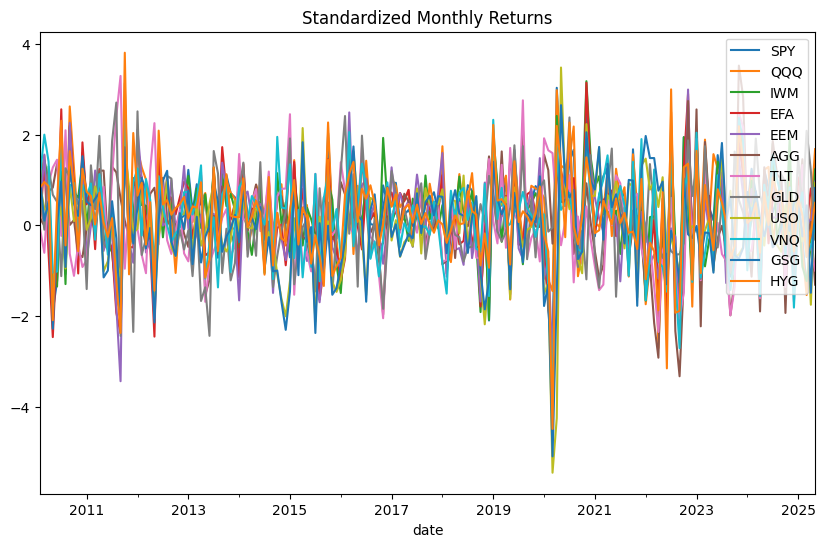

In [70]:
standardized_monthly_returns.plot(figsize= (10, 6), title = "Standardized Monthly Returns")
plt.legend(loc='upper right')
plt.show()


In [8]:
standardized_monthly_returns.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG
date,,,,,,,,,,,,
2010-02-28,0.744799,0.916251,0.779377,0.058755,0.341056,0.152548,-0.084637,0.721858,0.877883,1.095404,0.991881,0.836856
2010-03-31,1.454080,1.534952,1.434618,1.406373,1.558478,-0.005485,-0.606189,-0.096687,0.372571,1.998230,0.102850,0.954888
2010-04-30,0.369360,0.445268,0.988268,-0.617702,-0.033046,0.746710,0.927316,1.296866,0.253971,1.402850,0.527254,0.862233
2010-05-31,-1.897042,-1.470272,-1.312561,-2.465191,-1.803517,0.830458,1.274646,0.672783,-1.735678,-1.046639,-2.279431,-2.092595
2010-06-30,-1.235474,-1.225899,-1.349884,-0.456765,-0.269043,1.356188,1.445867,0.518985,-0.022835,-1.018873,0.012074,0.498842


# Load in Macro Data

In [35]:
FILE1             = "../data/Assignment_2_data.xlsm"

fed = pd.read_excel(FILE1, sheet_name='FF', index_col='Date')
fed.rename(columns={'Rate': 'ff'}, inplace=True)
fed = fed[~fed.index.duplicated(keep='last')]

fed = (fed            # daily EFFR
           .resample('ME').mean())   # trim to asset window

# select only >2010
fed = fed[fed.index >= '2008-01-01']
fed['rate_change_1m'] = fed['ff'].diff()

In [39]:
fed.head()

,ff,rate_change_1m
Date,,
2008-01-31,3.931429,NaN
2008-02-29,2.962500,-0.968929
2008-03-31,2.602857,-0.359643
2008-04-30,2.267727,-0.335130
2008-05-31,1.993333,-0.274394


<Axes: xlabel='Date'>

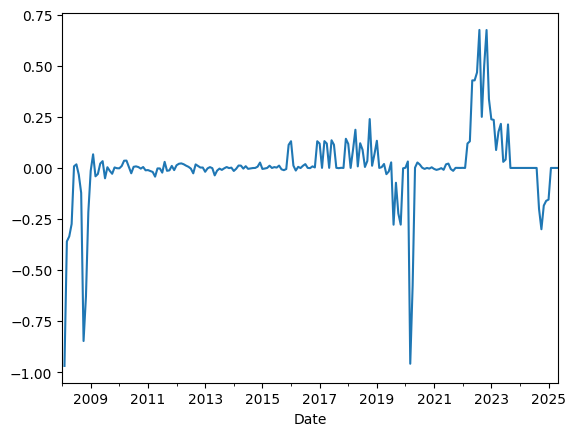

In [38]:
fed['rate_change_1m'].plot()

In [12]:
ism = pd.read_excel(FILE1, sheet_name='ISM', index_col='Date')
ism = ism[~ism.index.duplicated(keep='last')]
ism = ism[ism.index >= '2010-01-01']
ism


,ISM
Date,
2010-01-31,56.3
2010-02-28,55.5
2010-03-31,58.8
2010-04-30,58.1
2010-05-31,57.4
...,...
2024-12-31,49.2
2025-01-31,50.9
2025-02-28,50.3


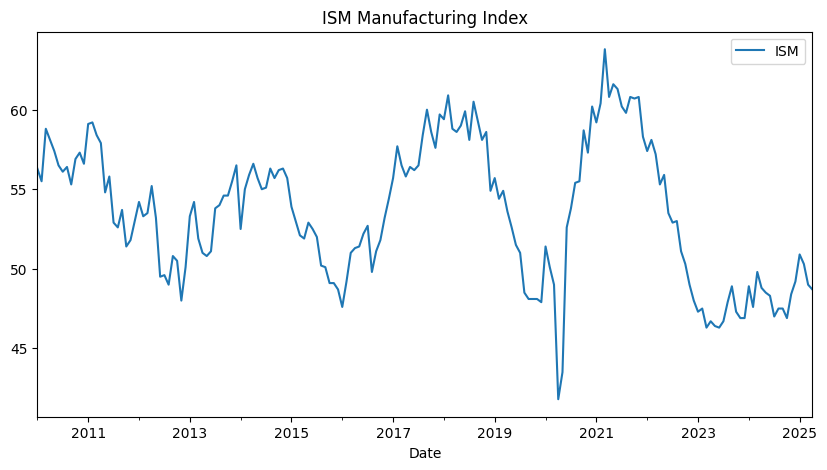

In [13]:
ism.plot(figsize = (10, 5))
plt.title("ISM Manufacturing Index")
plt.show()

In [14]:
nfp = pd.read_csv("../data/nonfarm_payrolls.csv", index_col = "observation_date")
nfp.index = pd.to_datetime(nfp.index)
nfp.rename(columns = {"PAYEMS": "nfp"}, inplace = True)
nfp.index.name = "Date"
nfp = nfp.resample('ME').mean()
nfp.head()

,nfp
Date,
2010-01-31,129802.0
2010-02-28,129705.0
2010-03-31,129865.0
2010-04-30,130120.0
2010-05-31,130643.0


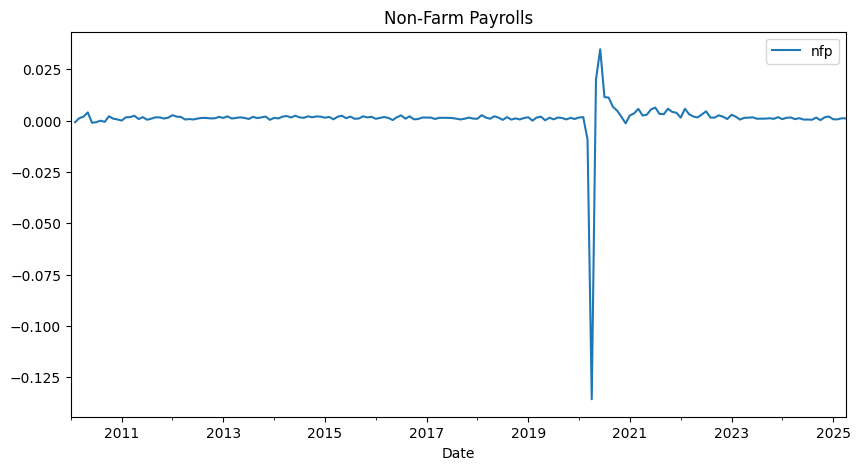

In [15]:
nfp.pct_change().plot(figsize = (10, 5))
plt.title("Non-Farm Payrolls")
plt.show()

In [41]:
pce = pd.read_csv("../data/core_pce.csv", index_col = "observation_date")
pce.index = pd.to_datetime(pce.index)
pce.rename(columns = {"PCEPILFE": "pce"}, inplace = True)
pce['pce_yoy'] = pce['pce'].pct_change(periods = 12)
pce.index.name = "Date"
pce = pce.resample("ME").mean()
pce

,pce,pce_yoy
Date,,
2008-11-30,87.952,NaN
2008-12-31,87.909,NaN
2009-01-31,87.882,NaN
2009-02-28,87.952,NaN
2009-03-31,88.015,NaN
...,...,...
2024-11-30,123.716,0.028319
2024-12-31,123.980,0.028641
2025-01-31,124.398,0.026996


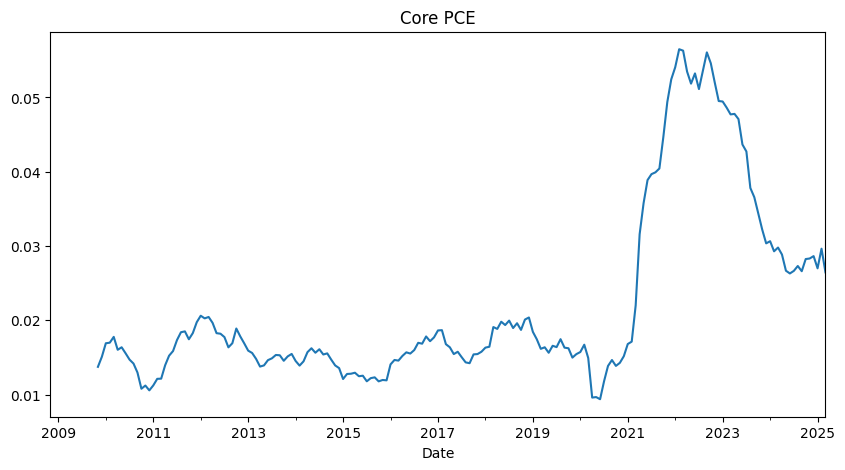

In [42]:
pce.pce_yoy.plot(figsize = (10, 5))
plt.title("Core PCE")
plt.show()

In [44]:
macro_factors = pd.concat([fed, ism, nfp, pce], axis = 1)
macro_factors
# macro_factors.columns = ['fed', 'ism', 'nfp', 'pce', 'cpi']
macro_factors


,ff,rate_change_1m,ISM,nfp,pce,pce_yoy
Date,,,,,,
2008-01-31,3.931429,NaN,NaN,NaN,NaN,NaN
2008-02-29,2.962500,-0.968929,NaN,NaN,NaN,NaN
2008-03-31,2.602857,-0.359643,NaN,NaN,NaN,NaN
2008-04-30,2.267727,-0.335130,NaN,NaN,NaN,NaN
2008-05-31,1.993333,-0.274394,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-01-31,4.330000,-0.154762,50.9,159053.0,124.398,0.026996
2025-02-28,4.330000,0.000000,50.3,159155.0,125.017,0.029641
2025-03-31,4.330000,0.000000,49.0,159340.0,125.052,0.026455


In [48]:
all_data = pd.merge(standardized_monthly_returns, macro_factors, left_index =True, right_index = True)
all_data.dropna(inplace = True)
all_data.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG,ff,rate_change_1m,ISM,nfp,pce,pce_yoy
2010-02-28,0.744799,0.916251,0.779377,0.058755,0.341056,0.152548,-0.084637,0.721858,0.877883,1.095404,0.991881,0.836856,0.126316,0.009474,55.5,129705.0,89.446,0.016987
2010-03-31,1.454080,1.534952,1.434618,1.406373,1.558478,-0.005485,-0.606189,-0.096687,0.372571,1.998230,0.102850,0.954888,0.161739,0.035423,58.8,129865.0,89.579,0.017770
2010-04-30,0.369360,0.445268,0.988268,-0.617702,-0.033046,0.746710,0.927316,1.296866,0.253971,1.402850,0.527254,0.862233,0.197727,0.035988,58.1,130120.0,89.625,0.016030
2010-05-31,-1.897042,-1.470272,-1.312561,-2.465191,-1.803517,0.830458,1.274646,0.672783,-1.735678,-1.046639,-2.279431,-2.092595,0.202500,0.004773,57.4,130643.0,89.724,0.016369
2010-06-30,-1.235474,-1.225899,-1.349884,-0.456765,-0.269043,1.356188,1.445867,0.518985,-0.022835,-1.018873,0.012074,0.498842,0.176364,-0.026136,56.5,130509.0,89.767,0.015556


## Build out factor model using ISM and PCE

In [53]:
oos = all_data[all_data.index >= "2025-01-01"]
in_sample = all_data[all_data.index < "2025-01-01"]

In [67]:
spy_model = OLS(in_sample['EFA'], add_constant(in_sample[['rate_change_1m', 'ISM', 'pce_yoy']])).fit()
display(spy_model.summary())
y_pred = spy_model.predict(add_constant(oos[['rate_change_1m', 'ISM', 'pce_yoy']]))
y_actual = oos['EFA']

y_actual-y_pred

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EFA   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.060
Date:                Wed, 14 May 2025   Prob (F-statistic):              0.107
Time:                        17:48:17   Log-Likelihood:                -252.01
No. Observations:                 179   AIC:                             512.0
Df Residuals:                     175   BIC:                             524.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1425      0.981      1.165      0.246      -0.793       3.078
rate_change_1m     1.2827      0.570      2.251      0.026       0.158       2.407
ISM               -0.0140      0.018     -0.797      0.427      -0.049       0.021
pce_yoy          -13.6563      6.928     -1.971      0.050     -27.329       0.016
==============================================================================
Omnibus:                        1.872   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.471
Skew:                          -0.154   Prob(JB):                        0.479
Kurtosis:                       3.320   Cond. No.                     4.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

2025-01-31    1.195866
2025-02-28    0.618071
2025-03-31   -0.053580
Freq: ME, dtype: float64

In [64]:
oos['EFA']

2025-01-31    1.057400
2025-02-28    0.650404
2025-03-31    0.040497
Freq: ME, Name: EFA, dtype: float64